In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image, display

In [2]:
## NWS Station Data
filename_pattern = '/home/sbarc/students/nash/data/NWS_precip/station_data/'
df_KVBG = pd.read_csv(filename_pattern + 'KVBG.csv', header=6, skiprows=[7], sep=',', engine='python',
                      parse_dates=['Date_Time'])

df_KSBA = pd.read_csv(filename_pattern + 'KSBA.csv', header=6, skiprows=[7], sep=',', engine='python',
                      parse_dates=['Date_Time'])

df_KLAX = pd.read_csv(filename_pattern + 'KLAX.csv', header=6, skiprows=[7], sep=',', engine='python',
                      parse_dates=['Date_Time'])

## select only times between 2019-03-04 and 2019-03-7
df_list = []
for df in (df_KVBG, df_KSBA, df_KLAX):
    df['precip_accum_one_hour_set_1'].fillna(0)
    df['delta'] = (df['Date_Time']-df['Date_Time'].shift()).fillna(pd.Timedelta('0 minutes'))
    df['ans'] = df['delta'].apply(lambda x: x  / np.timedelta64(1,'m')).astype('int64')
    mask = (df['Date_Time'] > '2019-3-4') & (df['Date_Time'] <= '2019-3-7')
    df = df.loc[mask]
    df_list.append(df)

station_name = ['KVBG', 'KSBA', 'KLAX']
station_lat = [34.72944, 34.42611, 33.93806]
station_lon = [-120.57667, -119.84361, -118.38889]

## Precip from gauges is in precipitation accumulation (inch) in one hour, measured every ~5 min
# Need to convert to precip accumulated (mm) each minute measured each 5 minutes
# divide by 60 (minutes in an hour) and multiply by 5 minutes

y = [(df_list[0].precip_accum_one_hour_set_1/60.0)*df_list[0].ans, 
     (df_list[1].precip_accum_one_hour_set_1/60.0)*df_list[1].ans, 
     (df_list[2].precip_accum_one_hour_set_1/60.0)*df_list[2].ans]

In [8]:
lats = [34.73215589, 34.42205221, 33.95689668]
lons = [-120.60625, -119.83125, -118.35875]
### NOAA NEXRAD L3 RADAR
filename_pattern = '/home/sbarc/students/nash/data/NWS_N1P_NEXRAD_NXL3/netcdf/KVBX*.nc'
ds_KVBX = xr.open_mfdataset(filename_pattern)
ds_KVBX = ds_KVBX.sel(lat=slice(33, 35), lon=slice(-121., -118.))

filename_pattern1 = '/home/sbarc/students/nash/data/NWS_N1P_NEXRAD_NXL3/netcdf/KVTX*.nc'
ds_KVTX = xr.open_mfdataset(filename_pattern)
ds_KVTX = ds_KVTX.sel(lat=slice(33, 35), lon=slice(-121., -118.))

## select gridcells closest to gauge station location
lat_idx = [-4, -8, 12]
lon_idx = [5, 15, -5]
ds_KVBX = ds_KVBX.isel(lat=lat_idx, lon=lon_idx)
ds_KVTX = ds_KVTX.isel(lat=lat_idx, lon=lon_idx)

# ds_KVBX.load()
# ds_KVTX.load()

In [16]:
## Precip from radar is in est. precip accumulation (in) in one hour, measured every ~5 min
# Need to convert to precip accumulated each minute measured each 5 minutes
# divide by 60 (minutes in an hour) and multiply by 5 minutes
# multiply by 25.4 to covert from inches to mm

## Calculate the difference in time
dt = ds_KVBX.time.diff(dim='time')
dt = dt.values.astype('timedelta64[s]')
dt = (dt / np.timedelta64(1,'s')).astype('int64')
dt1 = np.repeat(dt, 9).reshape((1034, 3, 3))
y2 = ((ds_KVBX.ohp[:-1, :, :].fillna(0).values*25.4)/60.0)*(dt1/60.0)

In [5]:
### GPM
lats = [33.95, 34.45, 34.75]
lons = [-118.35, -119.85, -120.65]

def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(lat=slice(33, 35), lon=slice(-121., -118.))

filename_pattern =  '/home/sbarc/students/nash/data/GPM/imerg/3B*' 
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', concat_dim='time',
                       group='Grid', preprocess=preprocess)

# lat_idx = [-3, -6, 9]
# lon_idx = [3, 11, -4]
# ds = ds.isel(lat=lat_idx, lon=lon_idx)

# convert from mm/hour to mm accumulated each 30 minutes
y3 = ds.precipitationCal.values/2.0

In [6]:
dates1 = [mpl.dates.date2num(df_list[0].Date_Time), mpl.dates.date2num(df_list[1].Date_Time),
          mpl.dates.date2num(df_list[2].Date_Time)]

dates2 = mpl.dates.date2num(ds_KVBX.time.values)


dates3 = mpl.dates.date2num(ds.indexes['time'].to_datetimeindex())

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  import sys


In [15]:
np.cumsum(ds_KVBX.ohp[:, 0, 0].fillna(0).values*25.4)

array([  0.        ,   0.        ,   0.        , ..., 165.10000246,
       165.10000246, 165.10000246])

(737121.853314236, 737125.1481325232)
(737121.8532326388, 737125.1498460649)
(737121.8532326388, 737125.1498460649)
./figures/precip_comparison.png


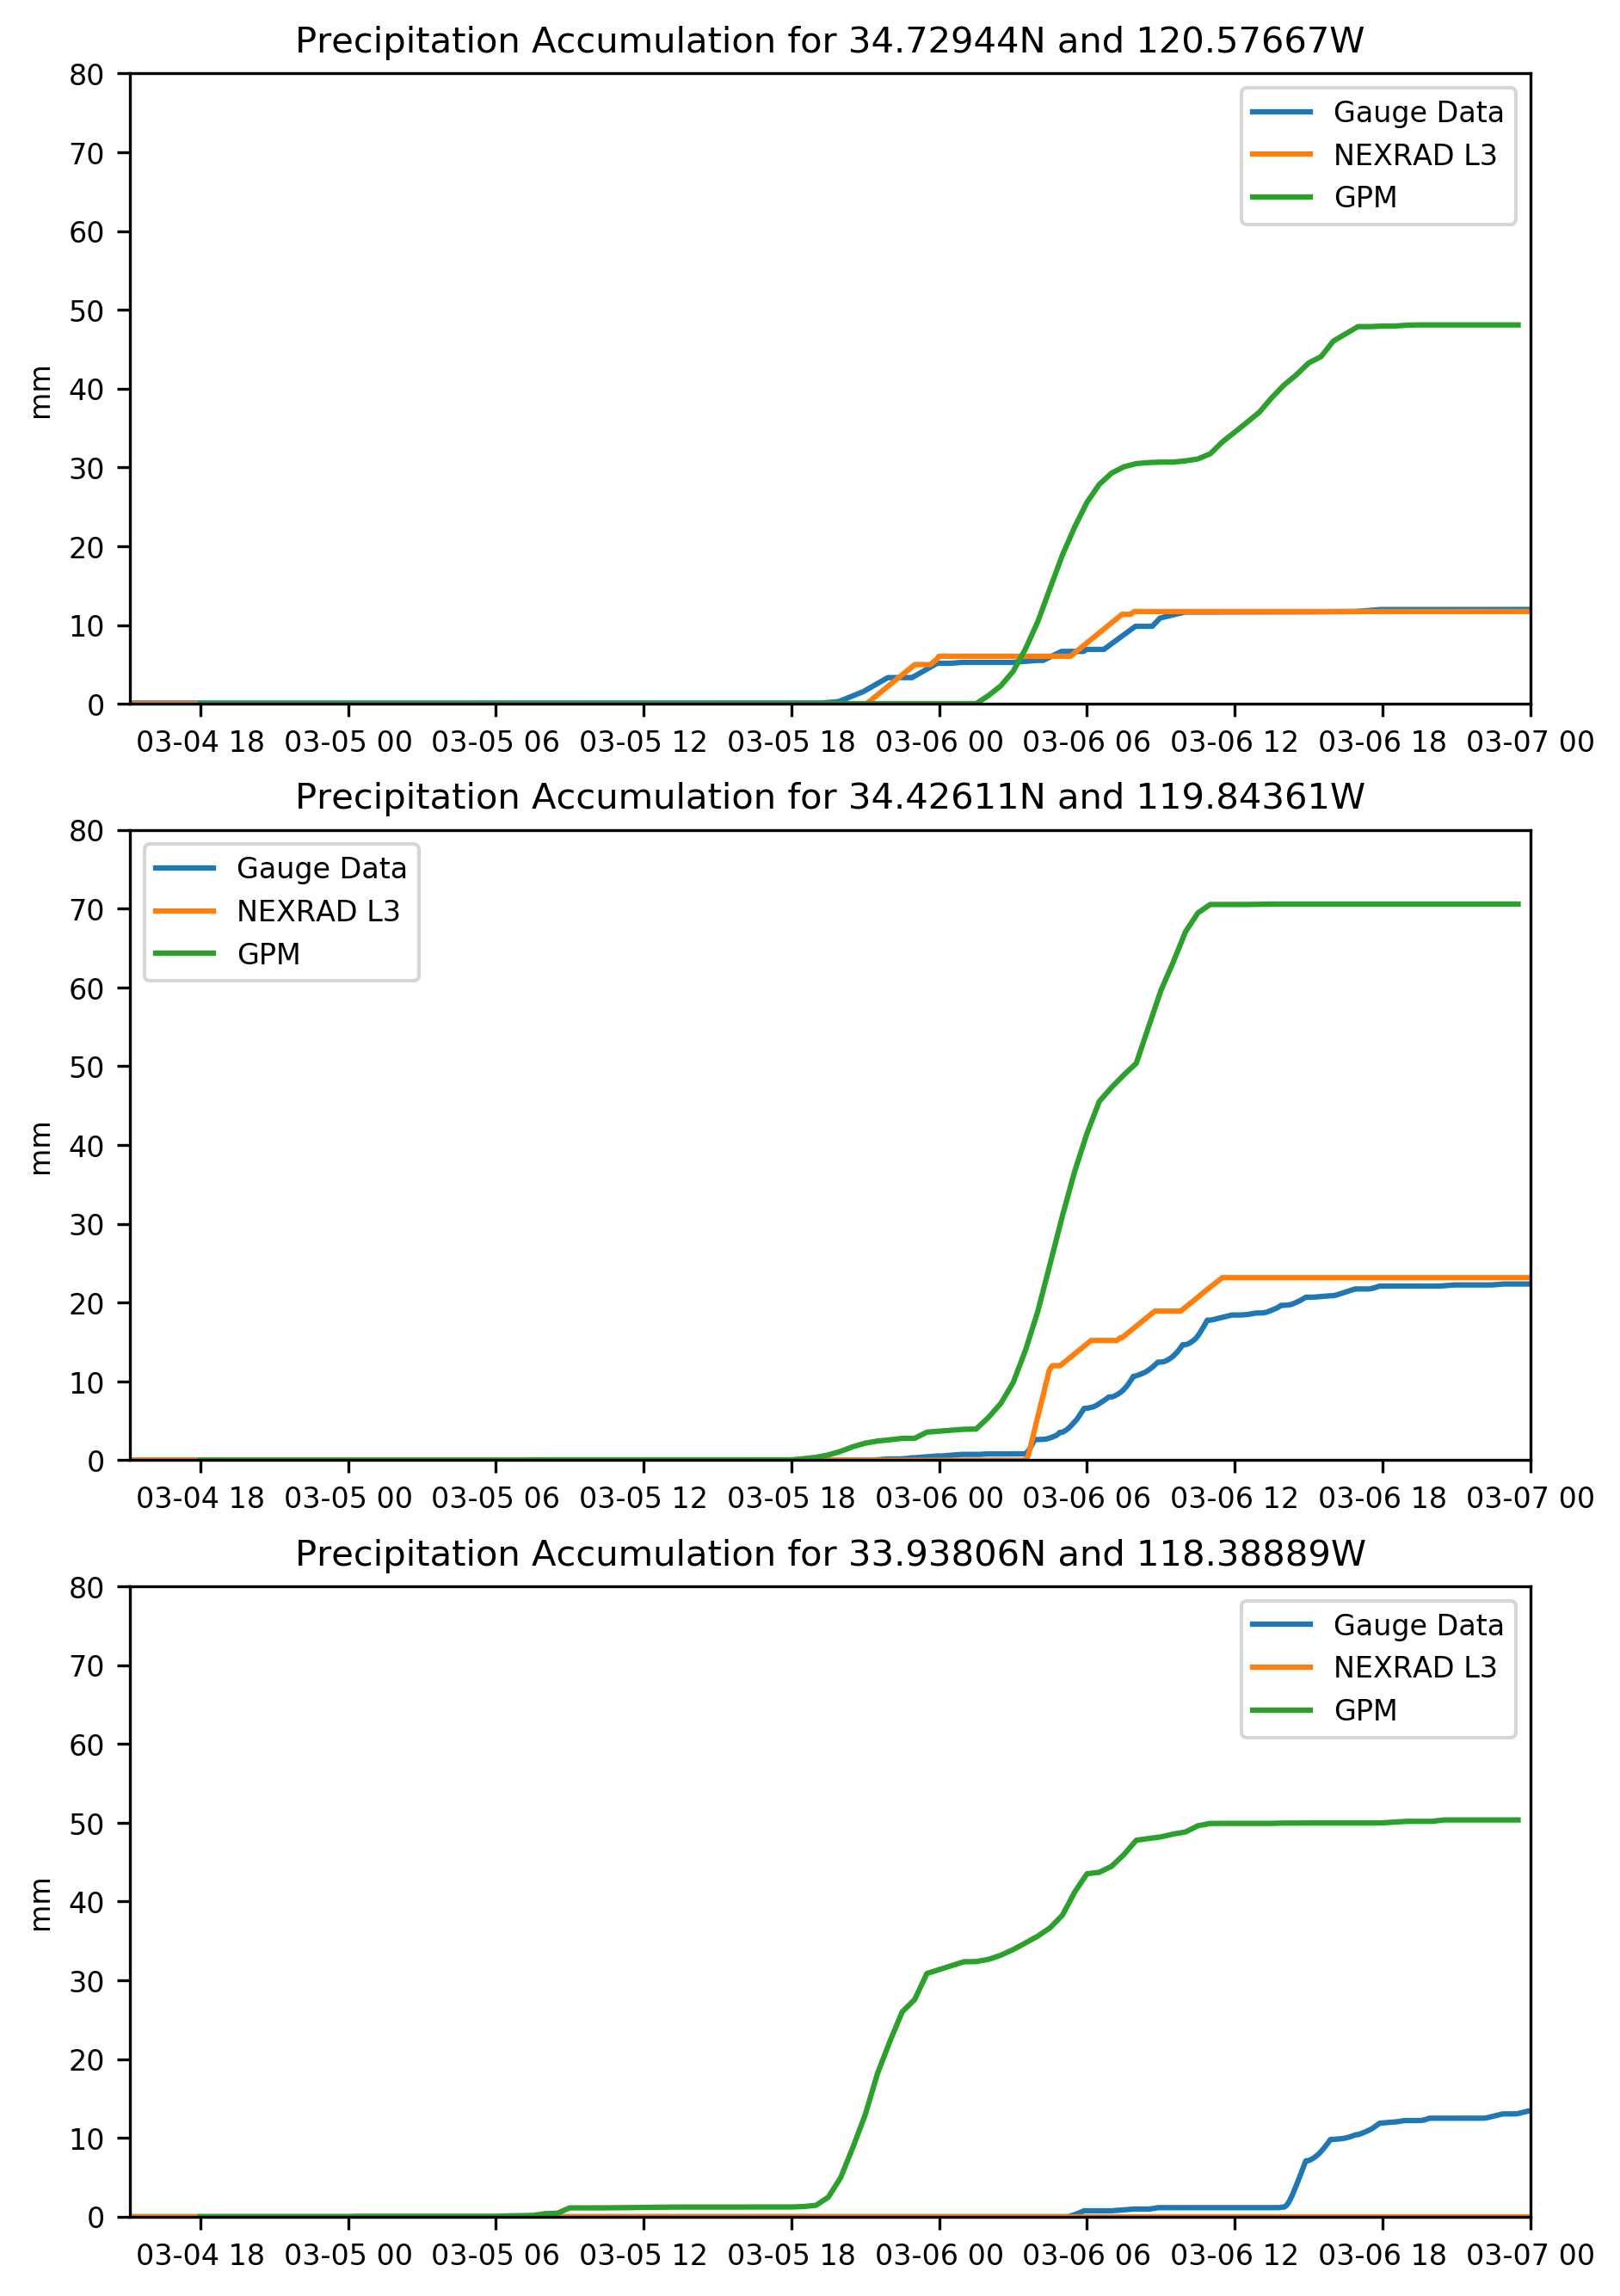

<Figure size 2100x3300 with 0 Axes>

In [29]:
gpm_lats = [33.95, 34.45, 34.75]
gpm_lons = [-118.35, -119.85, -120.65]
lat_idx = [-3, -6, 9]
lon_idx = [3, 11, -4]

station_lat = [34.72944, 34.42611, 33.93806]
station_lon = [-120.57667, -119.84361, -118.38889]

fig = plt.figure(figsize=(7, 11))
fig.dpi = 300
fname = './figures/precip_comparison'
fmt1 = 'png'

# x = [df_KVBG.Date_Time, df_KSBA.Date_Time, df_KLAX.Date_Time]
j = [2, 1, 0]
for i in np.arange(len(j)):
    ax = plt.subplot(3, 1, 1+i)
    y_plot = np.cumsum(y[i].fillna(0))
    gauge = ax.plot_date(dates1[i], y_plot, label='Gauge Data', ls='-', marker=None)
    y2_plot = np.cumsum(y2[:, i, i])
    KVBX = ax.plot_date(dates2[:-1], y2_plot, label='NEXRAD L3', ls='-', marker=None)
#     y3_plot = np.cumsum(ds_KVBX.ohp[:, i, i].fillna(0).values*25.4)
#     KVBX = ax.plot(ds_KVBX.time.values, y3_plot, label='NEXRAD L3')
    # Get GPM data
    q = j[i]
    gpm_data = np.cumsum(ds.precipitationCal.isel(lat =lat_idx[q], lon=lon_idx[q]).values/2.0)
    GPM = ax.plot_date(dates3, gpm_data, label='GPM', ls='-', marker=None)
    ax.set_ylim([0, 80])
    plt.ylabel('mm', fontsize=8)
    ax.tick_params('both', labelsize=8)
    print(ax.get_xlim())
    ax.set_xlim([737122.6314930555, 737125.])
    title = 'Precipitation Accumulation for {0}N and {1}W'.format(station_lat[i], station_lon[i]*-1)
    plt.title(title, fontsize=10)
    ax.legend(fontsize=8)

fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))